In [341]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,-60.350,-46.133,NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,19.87,133.88
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,12.60,56.80
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,74.885,16.048,20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,12.60,56.80


In [342]:
#Sile ut informasjon:
df = df[(df['Art - FDIR (kode)'] == 1022) | (df['Art - FDIR (kode)'] == 1027)] # Fiske som fanger hyse eller torsk. "751 - lodde, 1022 Torsk"
area = [7, 8, 28, 30, 40]
df = df[(df['Redskap FDIR (kode)'] == 51) & (df['Hovedområde start (kode)'].isin(area))] # Fiske med bunntrål - 51, snurrevad - 11
df['Bruttotonnasje Kombinert'] = df['Bruttotonnasje 1969'].fillna(df['Bruttotonnasje annen']) # Slår sammen kolonnene.
# Dropper unødvendig informasjon. Tabellen inneholder masse duplikater. som egen kolonne for navn og for kode
# Forskjellige klassifiseringsmåter. Holder på FDIR sine.
df.drop(columns = ['Meldingsdato', 
                   'Meldingsklokkeslett', 
                   'Startdato',  
                   'Hovedområde start', 
                   'Lokasjon start (kode)', 
                   'Stoppdato', 
                   'Stoppklokkeslett', 
                   'Fangstår', 
                   'Hovedområde stopp (kode)', 
                   'Hovedområde stopp', 
                   'Lokasjon stopp (kode)', 
                   'Redskap FAO (kode)', 
                   'Redskap FAO', 
                   'Redskap FDIR', 
                   'Hovedart FAO (kode)', 
                   'Hovedart FAO', 
                   'Art FAO (kode)',
                   'Art FAO',
                   'Art - gruppe', 
                   'Lengdegruppe', 
                   'Bredde', 
                   'Fartøylengde',
                   'Bruttotonnasje 1969',
                   'Bruttotonnasje annen'
    ], inplace=True)

# Gruppere bruttotonnasje:
bins = [x for x in range(0, 4800, 100)] # Definerer gruppene
labels = range(1, len(bins))  # nummererer gruppene.
# Categorize 'Bruttotonnasje Kombinert' into the defined bins
df['Bruttotonnasje Gruppert'] = pd.cut(df['Bruttotonnasje Kombinert'], bins=bins, labels=labels)
# Teller grupperingene
df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
6     992
3     950
2     618
21    465
4     433
35    312
14    305
32    261
5     257
25    233
1     210
12    191
16    186
15    181
40    164
38     78
26     50
7      49
23     45
19     44
45     17
17      8
42      5
44      0
46      0
41      0
33      0
37      0
36      0
43      0
34      0
39      0
24      0
31      0
30      0
29      0
28      0
27      0
22      0
20      0
18      0
13      0
11      0
10      0
9       0
8       0
47      0
Name: count, dtype: int64

In [343]:
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

aggregated_df = df.groupby(['Melding ID'], as_index=False).agg({
    'Startposisjon bredde': 'first',  # Antar at verdiene er lik for dei ulike radene. Tar med informasjon frå første raden som slås sammen
    'Startposisjon lengde': 'first',
    'Starttidspunkt': 'first',
    'Havdybde start': 'first',
    'Stopptidspunkt': 'last',
    'Varighet': 'sum', 
    'Stopposisjon bredde': 'last',  # Slår sammen og bruker verdien fra siste raden.
    'Stopposisjon lengde': 'last',
    'Havdybde stopp': 'last',
    'Trekkavstand': 'sum',  # summer opp dei ulike radene.
    'Redskap FDIR (kode)': join_unique_values,
    'Hovedart - FDIR (kode)': join_unique_values, # Tar med verdiene fra dei ulike radene og slår dei sammen til ein tekststreng.
    'Art - FDIR (kode)': join_unique_values,
    'Art - gruppe (kode)': join_unique_values,
    'Rundvekt': 'sum',  # Summing up the total weight
    'Lengdegruppe (kode)': 'first',  # Assuming to take the first value
    'Bruttotonnasje Gruppert': 'first'  # Assuming to take the first value
})
aggregated_df['Bruttotonnasje Gruppert'].value_counts()

Bruttotonnasje Gruppert
3     395
2     346
4     274
6     255
1     163
5     133
21    108
25     72
12     63
35     63
32     59
14     55
40     54
15     41
16     32
19     19
7      14
38     13
26      9
23      8
45      6
17      5
42      2
34      0
36      0
37      0
43      0
46      0
44      0
41      0
33      0
39      0
24      0
31      0
30      0
29      0
28      0
27      0
22      0
20      0
18      0
13      0
11      0
10      0
9       0
8       0
47      0
Name: count, dtype: int64

In [344]:
aggregated_df

,Melding ID,Startposisjon bredde,Startposisjon lengde,Starttidspunkt,Havdybde start,Stopptidspunkt,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,Lengdegruppe (kode),Bruttotonnasje Gruppert
0,1497555,57.588,6.834,01.01.2018 23:20,-229,02.01.2018 10:52,692,57.534,7.466,-237,38303.0,51.0,2524.0,1022.0,201.0,114.0,4.0,3
1,1497856,61.221,2.181,02.01.2018 12:00,-167,02.01.2018 17:30,330,61.481,1.753,-193,36931.0,51.0,1032.0,1022.0,201.0,100.0,5.0,21
2,1498229,58.318,6.210,03.01.2018 15:48,1,03.01.2018 16:59,142,58.328,6.200,41,2518.0,51.0,2524.0,"1022.0, 1027.0","201.0, 202.0",18.0,3.0,1
3,1498376,63.411,5.656,02.01.2018 22:57,-356,03.01.2018 19:00,1355,63.064,5.219,-266,44210.0,51.0,1032.0,"1022.0, 1027.0","201.0, 202.0",698.0,5.0,6
4,1498448,57.610,6.709,03.01.2018 12:17,-207,04.01.2018 01:03,766,57.537,7.447,-236,44900.0,51.0,2524.0,1022.0,201.0,72.0,4.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2184,1799925,62.650,4.067,29.12.2018 06:19,-188,29.12.2018 18:56,656,62.657,4.070,-188,8496.0,51.0,1032.0,1022.0,201.0,530.0,5.0,21
2185,1800158,62.650,4.122,30.12.2018 10:48,-187,30.12.2018 19:56,460,62.778,4.802,-145,19812.0,51.0,1032.0,1022.0,201.0,110.0,5.0,21
2186,1800218,62.834,5.510,30.12.2018 22:06,-96,31.12.2018 02:58,584,63.015,5.747,-151,46988.0,51.0,1027.0,"1027.0, 1022.0","202.0, 201.0",340.0,5.0,21
2187,1800245,57.774,5.861,31.12.2018 06:56,-187,31.12.2018 13:00,364,57.656,6.353,-158,32134.0,51.0,1032.0,1022.0,201.0,71.0,4.0,3


In [345]:
features = ['Bruttotonnasje Gruppert', 'Trekkavstand', 'Varighet', 'Havdybde start', 'Rundvekt']

df_cleaned = df.dropna(subset=features)

data = df_cleaned[features]
predict = 'Rundvekt'

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.020414859128940033


/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/1962164348.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bruttotonn_count = aggregated_df.groupby('Bruttotonnasje Gruppert').size()


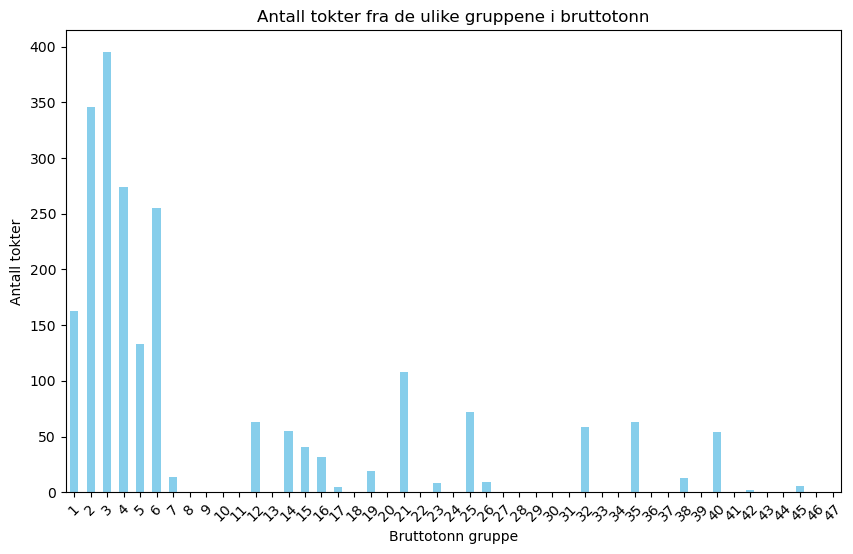

In [346]:
import matplotlib.pyplot as plt
# Gruppert etter størrelse på båten
bruttotonn_count = aggregated_df.groupby('Bruttotonnasje Gruppert').size()

# Genererer diagram
plt.figure(figsize=(10, 6))
bruttotonn_count.plot(kind='bar', color='skyblue')
plt.title('Antall tokter fra de ulike gruppene i bruttotonn')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Antall tokter')
plt.xticks(rotation=45)
plt.show()

In [347]:
# Group the data by 'Bruttotonnasje Gruppert' and calculate the sum of 'Rundvekt' for each group
rundvekt_total_per_group = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].sum()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/4084052864.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rundvekt_total_per_group = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].sum()


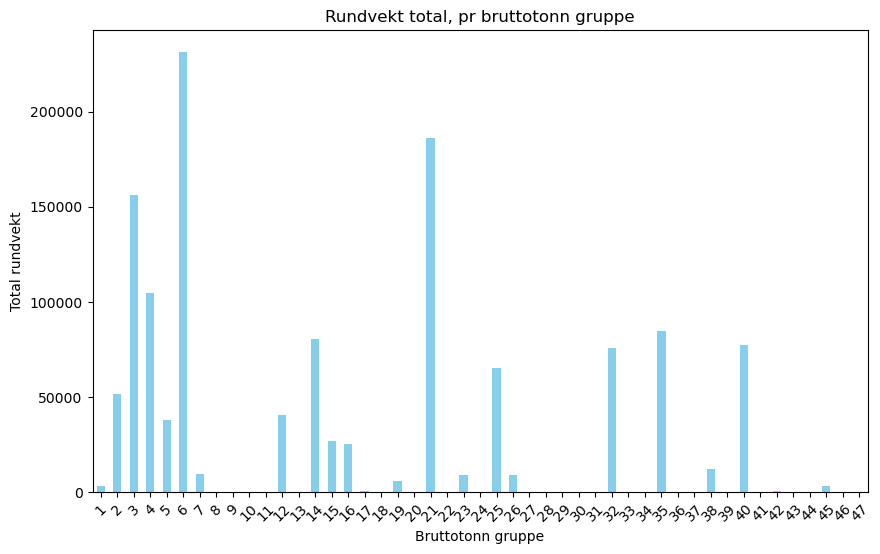

In [348]:
# Genererer diagram
plt.figure(figsize=(10, 6))
rundvekt_total_per_group.plot(kind='bar', color='skyblue')
plt.title('Rundvekt total, pr bruttotonn gruppe')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/1978392869.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()


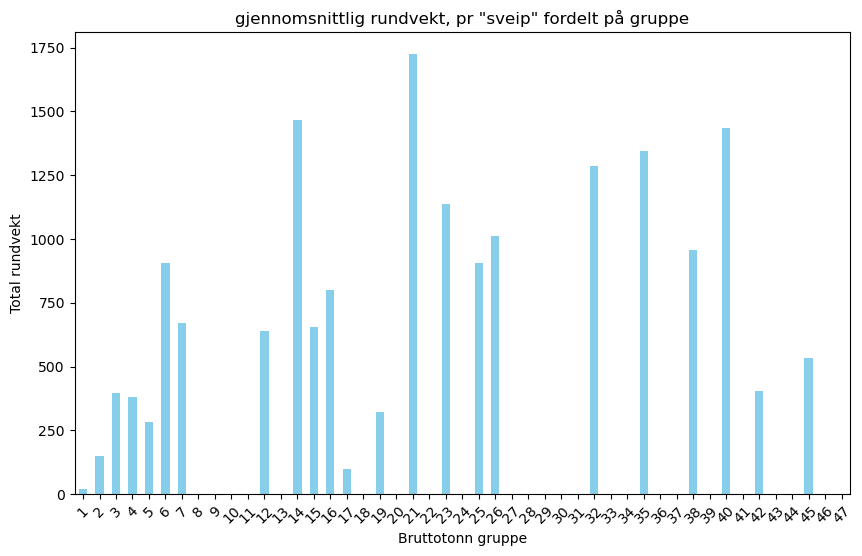

In [349]:
average_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].mean()

plt.figure(figsize=(10, 6))
average_rundvekt_gruppe.plot(kind='bar', color='skyblue')
plt.title('gjennomsnittlig rundvekt, pr "sveip" fordelt på gruppe')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

/var/folders/87/czlwvtcd4j3cz6jlhc_45ld00000gn/T/ipykernel_2333/815291654.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].max()


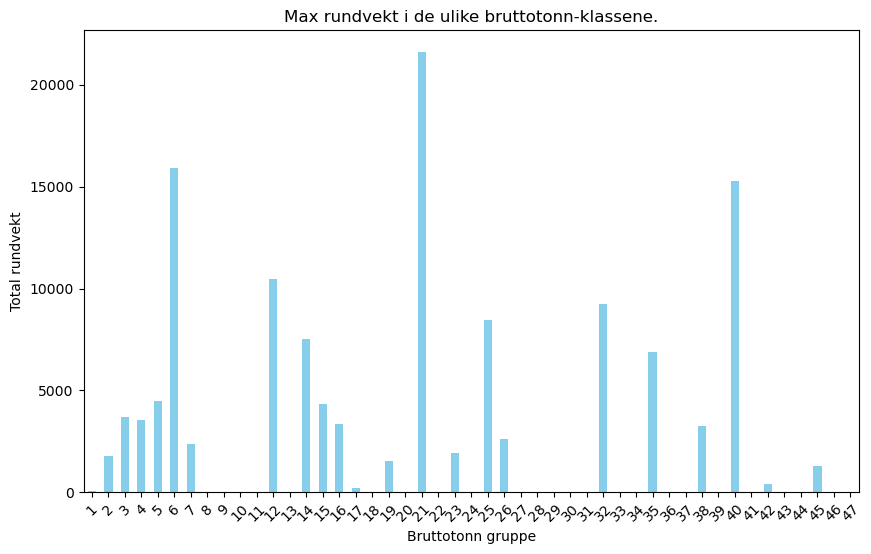

In [350]:
# Regne ut max kapasitet fra de ulike Bruttotonn-klassene.
max_rundvekt_gruppe = aggregated_df.groupby('Bruttotonnasje Gruppert')['Rundvekt'].max()

plt.figure(figsize=(10, 6))
max_rundvekt_gruppe.plot(kind='bar', color='skyblue')
plt.title('Max rundvekt i de ulike bruttotonn-klassene.')
plt.xlabel('Bruttotonn gruppe')
plt.ylabel('Total rundvekt')
plt.xticks(rotation=45)
plt.show()

In [351]:
# Finne ut forventet rundvekt pr klasse. 

In [352]:
features = ['Bruttotonnasje Gruppert', 'Trekkavstand', 'Varighet', 'Havdybde start', 'Rundvekt']

df_cleaned = aggregated_df.dropna(subset=features)

data = df_cleaned[features]
predict = 'Rundvekt'

X = np.array(data.drop([predict], axis=1))
y = np.array(data[predict])

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

linear = linear_model.LinearRegression()
linear.fit(x_train, y_train)
score = linear.score(x_test, y_test)
print(score)

0.22495614062905622


Resultater:
Rundvekt: 0.3073831319977236
Trekkavstand: 0.40293255889993773

In [353]:
print(len(y_train))
print(len(x_train))


1751
1751


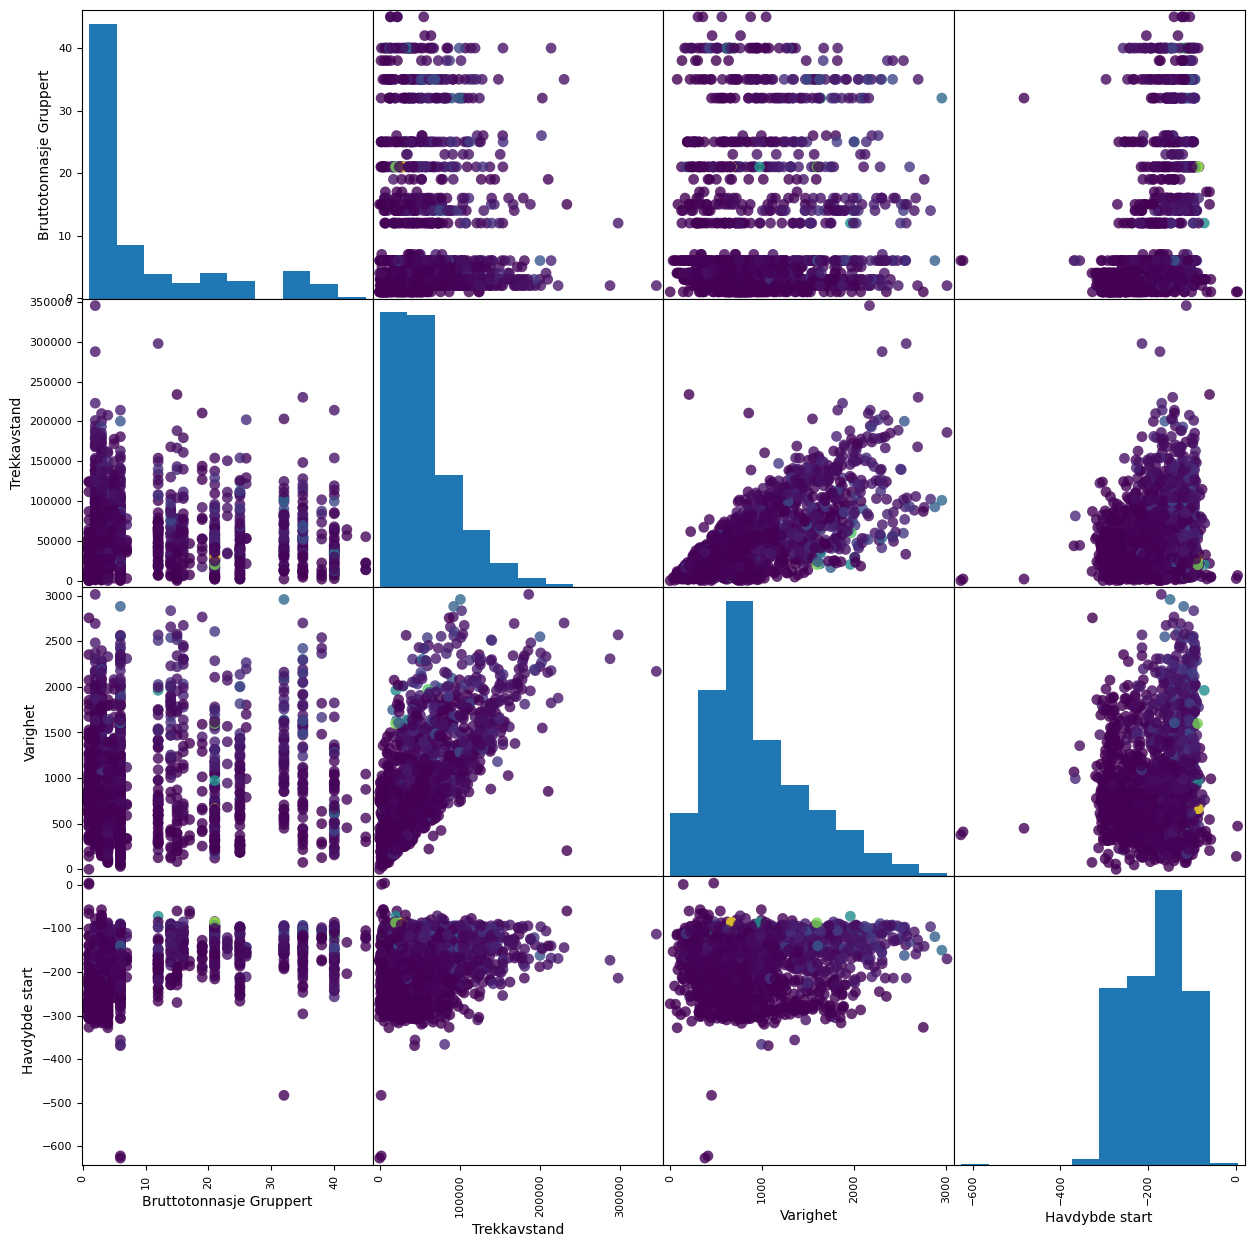

In [354]:
features.remove(predict)
# Assuming X and y_train are already defined
plot_frame = pd.DataFrame(x_train, columns=features)  # Use actual feature names

grr = pd.plotting.scatter_matrix(plot_frame, c=y_train, figsize=(15, 15), marker='o', s=60, alpha=.8)
plt.show()  # Ensure the plot displays in some environments